<a href="https://colab.research.google.com/github/hywkim-private/ALIGNet/blob/main/ALIGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torchvision
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2, wget
from zipfile import ZipFile
import h5py 

from pathlib import Path
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import random_split


In [ ]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9673 sha256=4e751ed5f419ea22541a40b8ad98436838482f9624521c81b7bb4dd5f69baa7a
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
#define hyper parameters 
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
EPOCHS = 20
BATCH_SIZE = 1
LEARNING_RATE = 0.1

TARGET_PROPORTION = 0.5
VAL_SIZE = 20
N_CLASS = 10
TEST_SIZE = 20


FILE_PATH = '../data/h5files'

In [ ]:
image_url = 'https://drive.google.com/uc?export=download&id=1Vv-Jz1VpI48MOVgK3Hq6ZYrs2NDP-FQ2'
filename = wget.download(image_url)
zf = ZipFile(filename, 'r')
zf.extractall('../data')
zf.close()

In [ ]:
#This class must be fine-tuned after completing the model, so as to be able to read from any h5 input formats
class Load_HDF5(Dataset):
  # if get_all == True, file_path must specifiy a directory, if not, it should specify a file
  # the class will crash if thi s requirement is not met
  def __init__(self, file_path, get_all = False, transform = None):
    self.path = file_path
    self.transform = transform
    #if filename is None, perform a recursive search over the file directory and retrieve all .h5 files
    p = Path(file_path)
    if get_all == True:
      files = sorted(p.glob('*.h5'))
      data_list = []
      for file in files:
        data_list.append(self.get_file(str(file)))
      self.data = data_list
    else:
      self.data = self.get_file(str(file))

  #given a filepath, return the image object
  def get_file(self, path):
    with h5py.File(path, 'r') as file:
      data = file['dep']
      data = data.get('view1')[:]
      return data
    
  def __getitem__(self, index):
    if len(self.data) <= index:
      print("__getitem__ERROR: index out of range")
      return 
    else:
      print(self.data)
      x = self.data[index]
      if self.transform:
        x = self.transform(x)
      return x

  def __len__(self):
    return len(self.data)

    
#visualize image given a data loader
def visualize_image(data_loader):
  index_counter = 1
  for i,batch_image in enumerate(data_loader):
    for k,image in enumerate(batch_image):
      
      image = image.squeeze()
      plt.figure(figsize=(10, 10))
      plt.subplot(len(data_loader),len(batch_image), index_counter)
      plt.imshow(image, cmap='gray')
      index_counter = index_counter + 1
   


In [ ]:
ds = Load_HDF5(FILE_PATH, get_all=True, transform=ToTensor())

#split data into train, validation, test sets
TRAIN_SIZE = len(ds)-VAL_SIZE-TEST_SIZE
Trainset, Validset, Testset = random_split(ds,[TRAIN_SIZE, VAL_SIZE, TEST_SIZE])

Trainset_target, Trainset_source = random_split(Trainset, [int(TRAIN_SIZE*TARGET_PROPORTION), int(TRAIN_SIZE*(1-TARGET_PROPORTION))])
Validset_target, Validset_source = random_split(Validset, [int(VAL_SIZE*TARGET_PROPORTION), int(VAL_SIZE*(1-TARGET_PROPORTION))])
Testset_target, Testset_source = random_split(Testset, [int(TEST_SIZE*TARGET_PROPORTION), int(TEST_SIZE*(1-TARGET_PROPORTION))])

#make dataloaders for targets and sources
train_loader_target = DataLoader(Trainset_target, batch_size=BATCH_SIZE, shuffle=True)
train_loader_source = DataLoader(Trainset_source, batch_size=BATCH_SIZE, shuffle=True)
valid_loader_target = DataLoader(Validset_target, batch_size=BATCH_SIZE, shuffle=True)
valid_loader_source = DataLoader(Validset_source, batch_size=BATCH_SIZE, shuffle=True)
test_loader_target = DataLoader(Testset_target, batch_size=BATCH_SIZE, shuffle=True)
test_loader_source = DataLoader(Testset_source, batch_size=BATCH_SIZE, shuffle=True)



In [ ]:
#given mask_size, target_size, stride, and target_image, create as many masked target images as possible and return its corresponding dataset
def mask_target_2d(mask_size, stride, target_size, target_image):
  #define parameters to fine-tune the masking operation
  remainder = target_size % mask_size
  max_iter = int(target_size / mask_size)

  #even_remainder denotes whether the remaining pixel after masking the input image is even (default=false)
  even_remainder = False
  if remainder % 2 == 0:
    even_remainder = True
  #convert target image to numpy in order to ease type conversions
  target_image = np.array(target_image)
  starting_coordinate = [mask_size+int(remainder/2), mask_size+int(remainder/2)]
  #the current_coordinate denotes the upper-right-most coordinate of the mask 
  current_coordinate = [mask_size+int(remainder/2), mask_size+int(remainder/2)]
  #max_coordinate denotes the upper_right-most corner of the target image that the mask can reach
  max_coordinate = [target_size-int(remainder/2),target_size-int(remainder/2)]
  #dataset of masked images
  masked_arr = []
  #produce mask images until the mask reaches the upper_right corner of the target image (max_coordinate)
  while (current_coordinate[0] <= max_coordinate[0]) and (current_coordinate[1] <= max_coordinate[1]):
    print(f'{current_coordinate}')
    #turn all areas within the masking target into zero
    masked_image = target_image.squeeze()
    masked_image[current_coordinate[0]-mask_size:current_coordinate[0],current_coordinate[1]-mask_size:current_coordinate[1]] = 0
    #add the masked image to data array
    masked_arr.append(masked_image)
    #update current_coordinate along the x-axis
    current_coordinate[0] = current_coordinate[0] + stride
    #if the mask reaches the max of the x axis, move up to the y axis 
    if current_coordinate[0] >= max_coordinate[0]:
      current_coordinate[1] = current_coordinate[1] + stride
      current_coordinate[0] = starting_coordinate[0] 
    
  masked_arr = np.array(masked_arr).squeeze()
  #after all iterations, convert the array data into dataset
  masked_ds = torch.FloatTensor(masked_arr)

  return masked_ds
    
  






In [ ]:
test_image = next(iter(train_loader_target))
#test cell for the function mask_target_2d
masked_ds = mask_target_2d(10, 10, 128, test_image)
masked_dl = DataLoader(masked_ds, batch_size=BATCH_SIZE, shuffle=True)


[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0.

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


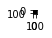

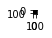

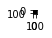

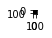

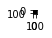

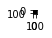

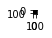

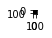

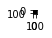

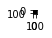

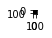

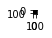

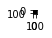

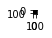

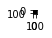

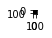

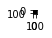

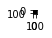

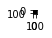

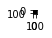

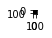

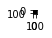

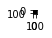

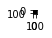

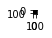

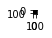

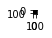

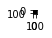

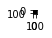

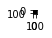

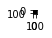

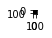

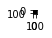

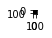

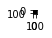

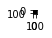

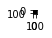

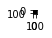

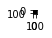

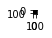

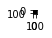

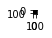

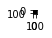

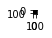

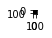

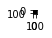

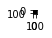

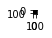

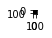

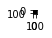

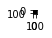

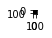

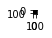

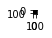

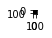

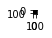

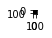

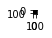

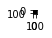

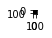

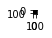

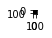

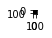

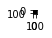

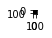

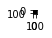

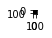

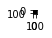

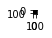

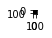

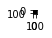

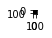

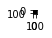

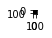

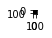

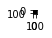

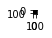

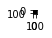

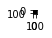

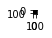

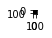

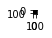

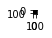

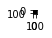

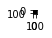

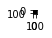

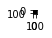

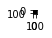

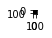

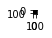

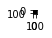

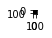

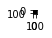

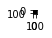

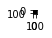

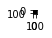

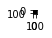

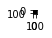

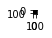

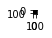

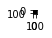

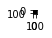

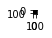

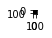

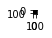

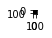

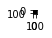

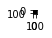

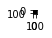

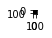

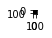

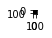

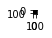

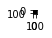

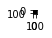

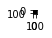

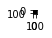

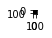

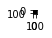

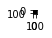

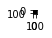

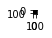

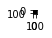

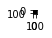

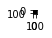

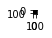

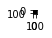

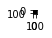

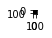

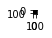

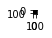

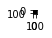

In [ ]:
test_image2 = next(iter(masked_dl))
print(test_image2)
visualize_image(masked_dl)

In [ ]:
 print(test_image)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], dtype=torch.float64)


view1


view1


In [ ]:
print(Trainset_target[0])

TypeError: ignored

<HDF5 dataset "view1": shape (128, 128), type "<f8">


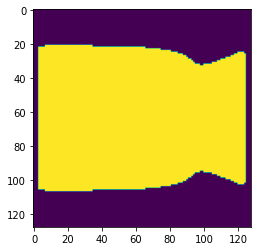

AttributeError: ignored